<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/FFNNExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Final assignment description </h1>

The objective is to classify three different classes of ECG signals.
-<h3> Normal sinus rythm; </h3> <br> 
![Normal sinus rythm](img/normal.PNG)
-<h3> Premature ventricular complex (PVC); </h3> <br>
![PAC](img/pvc.PNG)
-<h3> Premature atrial complex (PAC); </h3> <br>
![PVC](img/pac.PNG)


We must classify each beat of the signal and each beat of the training set is labelled with:
- N: normal sinus rythm; <br>
- S: supraventricular beats (PAC); <br>
- V: ventricular beats (PVC); <br>

<h2>Dataset </h2>

- 105 patients;
- fs: 128 or 250 Hz;
- 2 leads ECG -> 2 ecg signal for each patient; 
- Rpeaks are annotated in the dedicated .mat file;

File format: 
- [PatientID]\_[fs]+".mat" $\rightarrow$ 2 leads ECG signal;
- [PatientID]\_[fs]+\_[ann]+".mat" $\rightarrow$ labelling of the Rpeaks;
- [PatientID]\_[fs]+\_[rpk]+".mat" $\rightarrow$ Rpeaks location in the signal (at which time an Rpeak appears);



In [1]:
!pip install heartpy

In [2]:
import os
import gc
import tensorflow as tf
from tensorflow import keras

from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import keras.backend as K
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import pandas as pd
from scipy.signal import butter, lfilter
import heartpy as hp

from sklearn.preprocessing import MaxAbsScaler, StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight

import seaborn as sns


from keras.preprocessing.sequence import pad_sequences
import math
import random
import zipfile  
import io
from PIL import Image

In [15]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [3]:
#Test if GPU is available for tensorflow
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

In [ ]:
#IF Colab cloud GPU used -> Mount the My Drive folder and set cwd
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#IF jupyter is used locally
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

In [4]:
import numpy as np 
import os 
from scipy.io import loadmat 
import matplotlib.pyplot as plt 

def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
  label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
  peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
  signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
  if os.path.isfile(label_filepath):
    mat_file = loadmat(label_filepath)
    label = np.asarray(mat_file['labels'])
  if os.path.isfile(peak_filepath):
    mat_file = loadmat(peak_filepath)
    peaks = np.array(mat_file['rpeaks'])
    peak = list()
    for p in peaks:
      peak.append(p[0])

  if os.path.isfile(signal_filepath):
    mat_file = loadmat(signal_filepath)
    signal = np.asarray(mat_file['ecg'] )

  return label, peak, signal

# this function creates a patch for the defined signal & peak and save it in the "dataset_folder/Patches" folder 
# under the name of [SIGNAL_ID]_[peakID]_[LABEL].png

# there is a problem: sopraventricular beats (PAC complex) are hard to distinguish from the normal sinus beat
def create_patch(ecg_signals,rpeaks,sigID,peakID):
    
    signal = ecg_signals[sigID]

    prev = rpeaks[sigID][peakID-1]
    peak = rpeaks[sigID][peakID]
    succ = rpeaks[sigID][peakID+1] 
    x = np.arange(int((peak+prev)/2),int((peak+succ)/2)) # lowest x is equal to the average between the peakID and the previous, dual for the highest x 
    y = signal[x,0]
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=2.0)
    
    plt.axis('off')         # axes are useless in input to the model 

In [5]:
#from utils.data_loading import load_data

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

In [ ]:
print(rpeaks[0][0])

29


<h2>Data visualization</h2>

In [6]:
def set_ax_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
def plot_signal(sigID,length,peakNum,signals=ecg_signals, w_size=12, h_size=3):

    """
    Plot first & second lead ecg signal for a fixed length of samples, centered at indexed peak
        :param int sigID: the index of the signal
        :param int length: the number of samples to be plotted
        :param signals: the ecg_signals list
        :param int lead: the lead to be plotted
    """
    peak = rpeaks[sigID][peakNum]
    signal = np.asarray(signals[sigID]).astype(np.float32)

    x = list()

    range_ = range(int(peak-length/2),int(peak+length/2))
    for r in range_:
        if(r >= 0):
            x.append(r)

    y_first_lead = signal[x,0]
    y_second_lead = signal[x,1]
    fig, axs = plt.subplots(2)
    set_ax_size(w_size,h_size)
    axs[0].set_title(label="First and second lead")
    
    axs[0].plot(x, y_first_lead, linewidth=2.0)
    axs[1].plot(x,y_second_lead,linewidth=2.0)


    #we are plotting only the defined time, so we must count how many peaks 
    indexes = list()
    
    for i,p in enumerate(rpeaks[sigID]):
        if (p >= peak-length/2 and p <= peak + length/2):
            indexes.append(i)
    
    x = [rpeaks[sigID][i] for i in indexes]  # time values of the peaks in between the defined length 
    y_first = signals[sigID][x,0]         # amplitude value of the peaks for first lead 
    y_second = signals[sigID][x,1]
    
    axs[0].scatter(x,y_first,color = "red")
    axs[1].scatter(x,y_second,color = "red")

    peaks_labels = labels[sigID][indexes] 
    offset = 15
    for i,label in enumerate(peaks_labels):
        axs[0].annotate(label,(x[i]-offset,y_first[i]),fontsize = "large")
        axs[1].annotate(label,(x[i]-offset,y_second[i]),fontsize = "large")

    plt.show()
    

def plot_comparison(raw_signal, filtered_signal, sigID, length, peaks=rpeaks, labels=labels, lead=0, title = "", w_size=12, h_size=3):
  """
    Method that plots on the same graph both raw and filtered ECG signal for a given number of samples.
      :param raw_signal: the raw ECG signal
      :param filtered_signal: the same ECG signal after manipulation
      :param int sigID: the index of the signal
      :param int length: the number of samples to be plotted
      :param peaks: the rpeaks list
      :param labels: the rpeaks labels list
      :param int lead: the lead to be plotted
      :param string title: optional title of the plot
  """
  peaks_temp = peaks[sigID]
  plotted_samples  = length
  fig, ax = plt.subplots()
  set_ax_size(w_size,h_size)
  ax.plot(raw_signal[:plotted_samples,lead])
  ax.plot(filtered_signal[:plotted_samples,lead])

  ax.set_title(title)
  peak_counter=0
  for peak_sample in peaks_temp:
    if peak_sample > plotted_samples:
      break
    peak_counter +=1
    ax.plot(peak_sample, raw_signal[peak_sample,lead] , marker="o", color="red", alpha=.5)
    ax.plot(peak_sample, filtered_signal[peak_sample,lead] , marker="+", color="blue", alpha=.5)


  offset = 20
  peaks_labels = labels[sigID][:peak_counter]
  for i,label in enumerate(peaks_labels):
    ax.annotate(label,(peaks_temp[i]-offset,raw_signal[peaks_temp[i],lead]),fontsize = "large")

  plt.show()

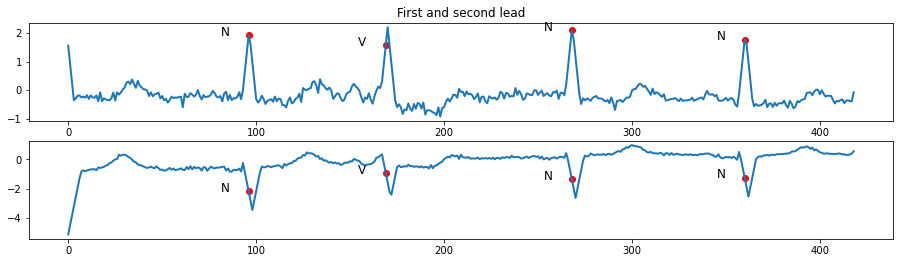

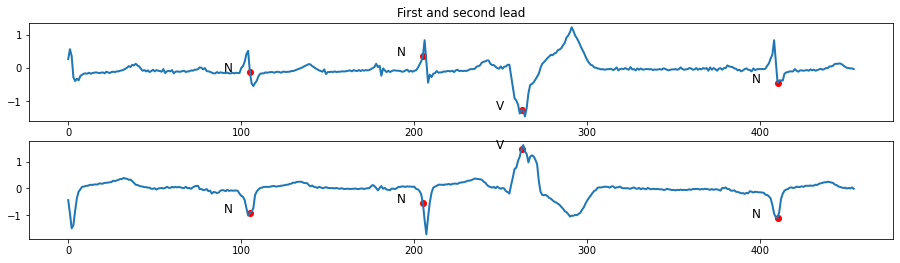

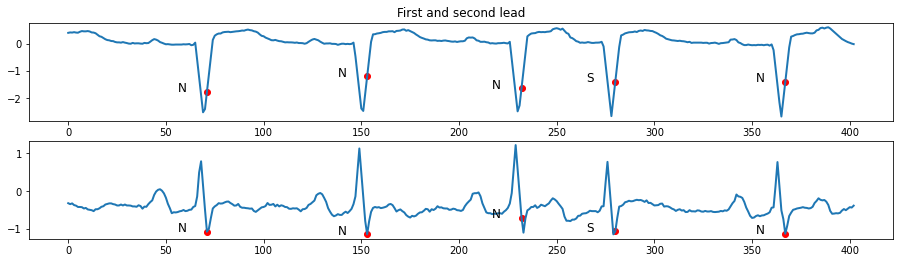

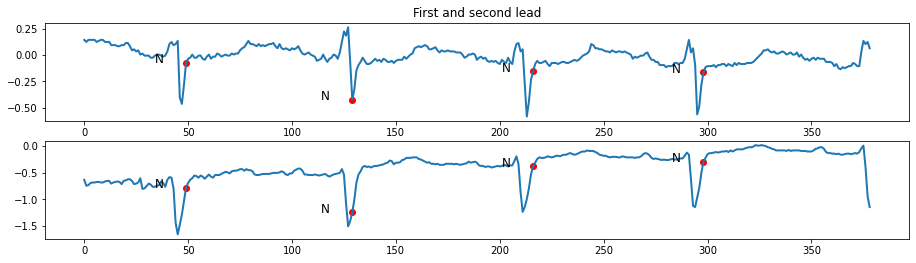

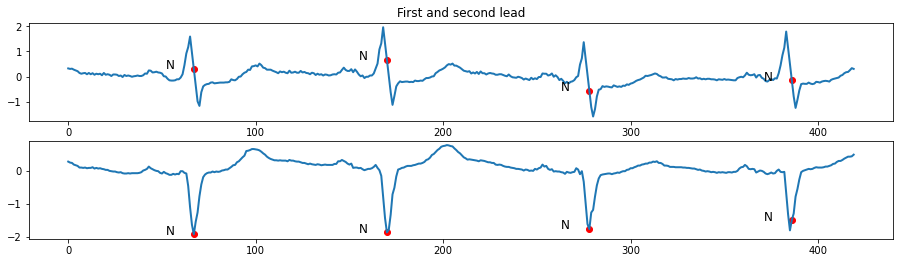

In [ ]:
# plot first 5 signals 
for i in range(5):
    plot_signal(i,500, 1)


Text(0.5, 1.0, 'Signal length distribution')

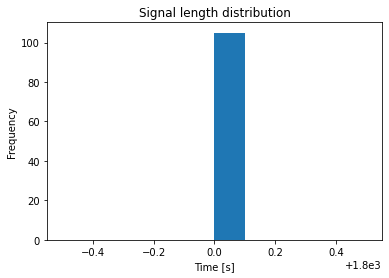

In [ ]:
#Compute the duration in seconds of each signal
#Iterate through the different signals: store signal length and divide by sampling frequenzy to obtain it in senconds.
length_recordings = list()
for i, signal in enumerate(ecg_signals):
  length_recordings.append(len(signal[:])/frequencies[i])


# Transform to pandas series and plot histogram.
length_rec_s = pd.Series(length_recordings)
ax = length_rec_s.plot.hist(bins= 10)
ax.set_xlabel("Time [s]")
ax.set_title("Signal length distribution")

Each ecg has a total duration of 1800 seconds, both the ones at 180 and 250 Hz. The latter have a greater number of samples.

#Apply a bandpass filter
...
#Use heartpy lib methods
...

# Filter using Convolution
Another way to low-pass a signal is to use convolution. In this method you create a window (typically a bell-shaped curve) and convolve the window with the signal. The wider the window is the smoother the output signal will be. Also, the window must be normalized so its sum is 1 to preserve the amplitude of the input signal.

In [7]:
#Preprocessing used in practical lessons
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """

        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

def signal_preprocessing(data, max_length, lowcut= 1, highcut = 47, signal_freq = 500, filter_order = 3, apply_bandpass= True, remove_baseline_wander=False, apply_convolution = False, enhance_peaks =False): 
        """
        Method that applies a bandpass filter and use padding to make all the samples of equal length
        :param data: an ECG signal
        :param int max_length: the maximum length to which the sample will be padded
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :param boolean remove_baseline_wander: if True, apply heartpy remove_baseline_wander to the signal
        :param boolean apply_convolution: if True, apply convolution to improve signal smoothness
        :param boolean enhance_peaks: if True, apply heartpy enhance_peaks to the signal
        :return array: filtered and padded data
        """
        filtered_ecg=data.copy()
        #Potrebbe essere dopo aver applicato il filtro?
        if remove_baseline_wander:
          filtered_ecg[:,0] = hp.remove_baseline_wander(data[:,0], signal_freq)
          filtered_ecg[:,1] = hp.remove_baseline_wander(data[:,1], signal_freq)
          data=filtered_ecg
        if enhance_peaks:
          temp0 = np.array(hp.enhance_ecg_peaks(hp.scale_data(filtered_ecg[:,0], upper = 100), signal_freq, 
                                aggregation='median', iterations=5))
          temp1 = np.array(hp.enhance_ecg_peaks(hp.scale_data(filtered_ecg[:,1], upper = 100), signal_freq, 
                                aggregation='median', iterations=5))

          temp0.resize(filtered_ecg[:,0].shape)
          temp1.resize(filtered_ecg[:,1].shape)
          filtered_ecg[:,0] = temp0
          filtered_ecg[:,1] = temp1
          data=filtered_ecg

        

        if apply_bandpass:
          filtered_ecg = bandpass_filter(data, lowcut, highcut, signal_freq, filter_order)

        if apply_convolution:
          # https://swharden.com/blog/2020-09-23-signal-filtering-in-python/
          # create a normalized Hanning window
          windowSize = 5
          window = np.hanning(windowSize)
          window = window / window.sum()
          filtered_ecg[:,0] = np.convolve(window, filtered_ecg[:,0], mode='same')
          filtered_ecg[:,1] = np.convolve(window, filtered_ecg[:,1], mode='same')

        #Note that the padding may be changed, depending on the model input
        filtered_ecg = np.moveaxis(filtered_ecg, -1, 0)
        X = pad_sequences(filtered_ecg, maxlen=max_length, dtype='float32', truncating='post',padding="post")

        X = np.moveaxis(X, -1, 0) #in order to adapt the signal to the input of the network
        #Queste ultime due righe sono da controllare
        return X

In [8]:
#Compute max_length to apply padding and make all the signals of the same number of samples (they've all the same sampling time of 1800sec)
#If signals will be cropped, must be padded to multiple of the crop size
max_length  = 0
for signal in ecg_signals:
  if signal.shape[0] > max_length:
    max_length = signal.shape[0]


signals_filt = np.empty((len(ecg_signals),max_length,2))


for i, signal in enumerate (ecg_signals):
  if frequencies[i]==250:
    lowcut = 2#2
    highcut = 94 #47
  else:
    lowcut = 4#4 #0.256
    highcut = 60#47 #12.032

  #CHECK lowcut/highcut parameters and methods to be applied (remove_baseline / convolution / enhance_peaks)
  #filtered = signal_preprocessing(signal, max_length= max_length, signal_freq = frequencies[i], lowcut= lowcut, highcut = highcut, filter_order=3, remove_baseline_wander=True, apply_convolution=True)
  #filtered = signal_preprocessing(signal, max_length= max_length, signal_freq = frequencies[i], lowcut= lowcut, highcut = highcut, apply_bandpass=False, remove_baseline_wander=True, apply_convolution=True)
  filtered = signal_preprocessing(signal, max_length= max_length, signal_freq = frequencies[i], lowcut= lowcut, highcut = highcut, apply_bandpass=False, remove_baseline_wander=True, apply_convolution=True)
  signals_filt[i]= filtered





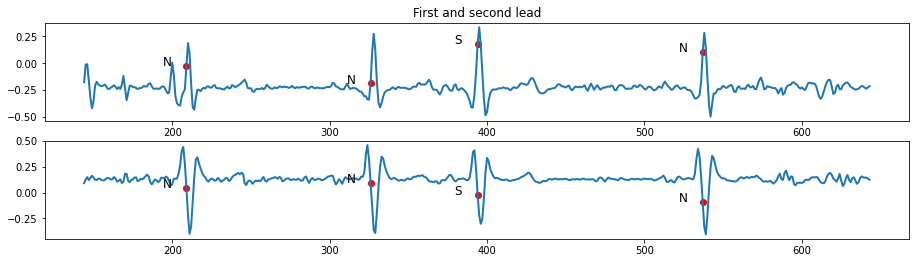

In [ ]:
plot_signal(2, 500, 3, signals_filt)

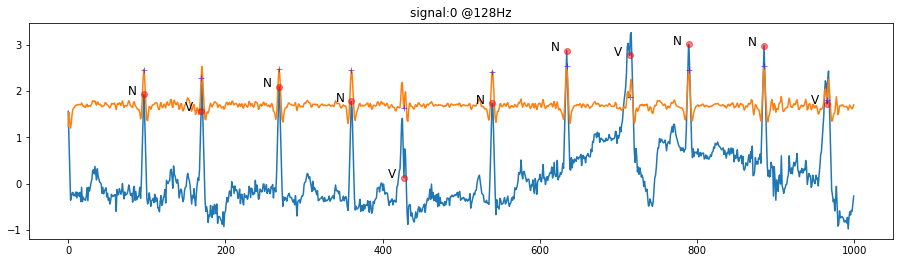

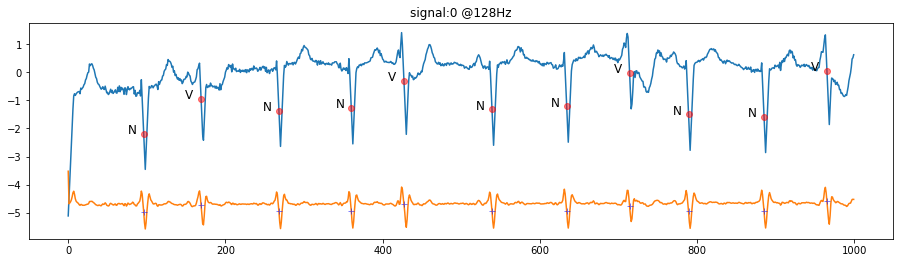

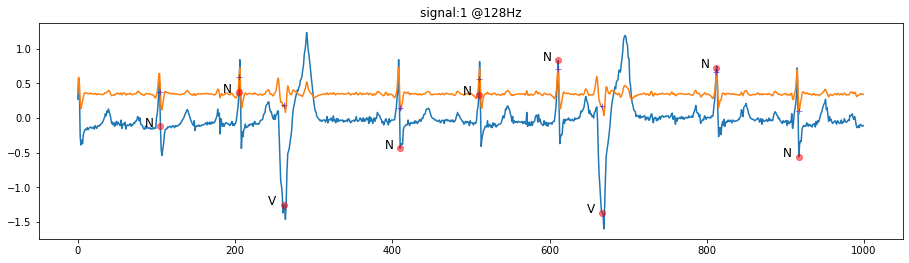

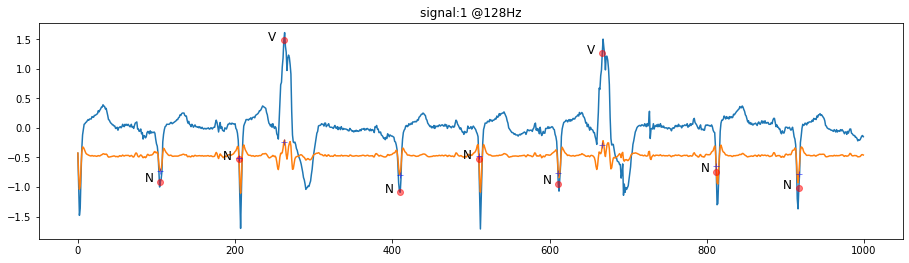

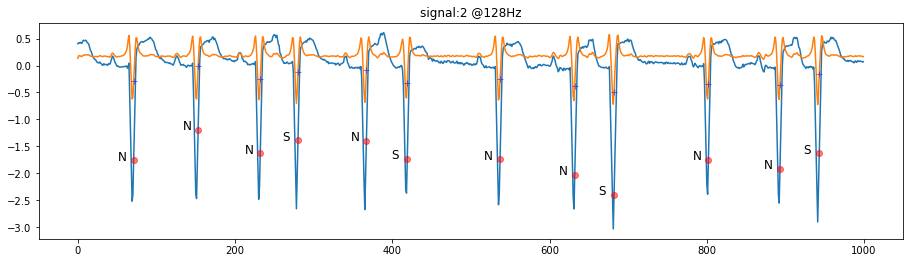

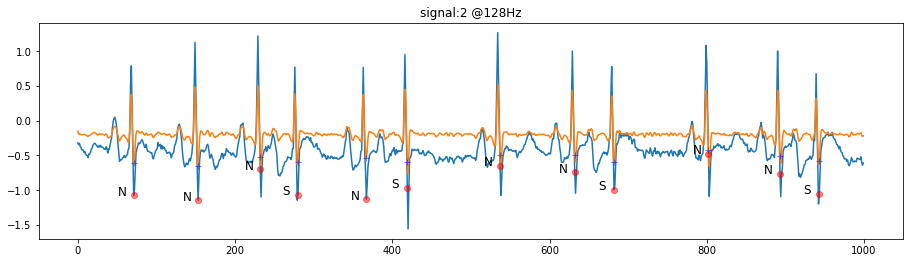

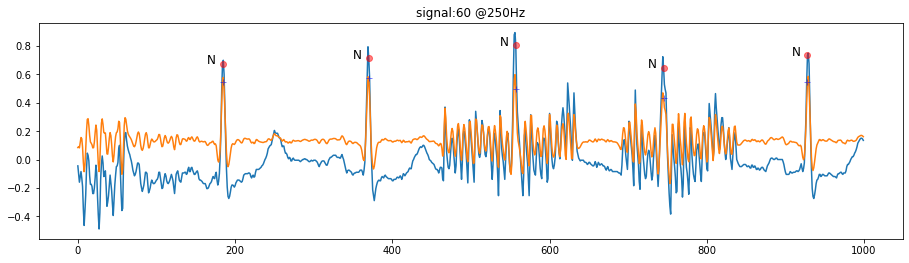

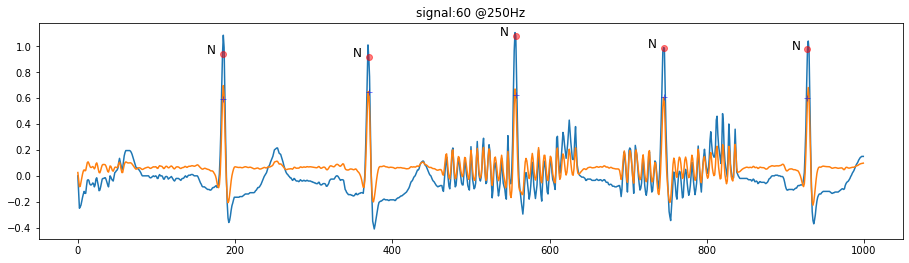

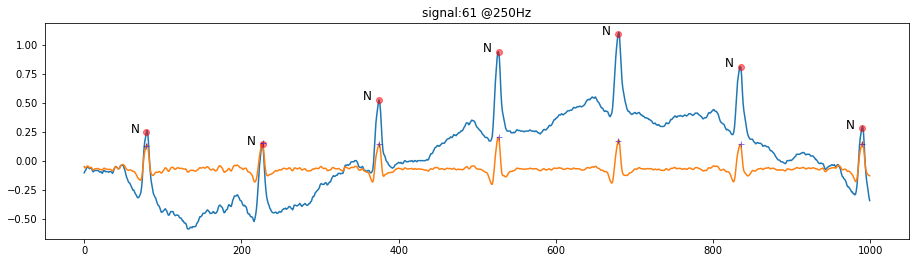

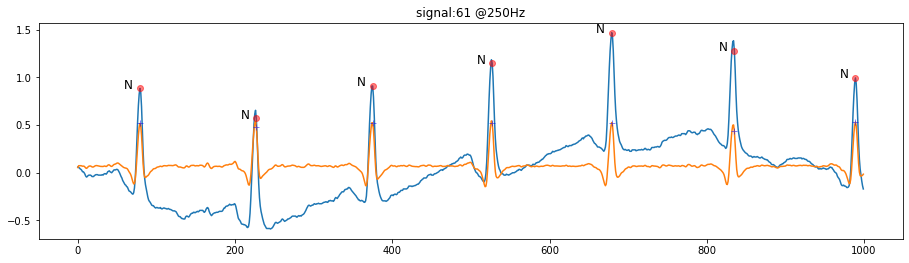

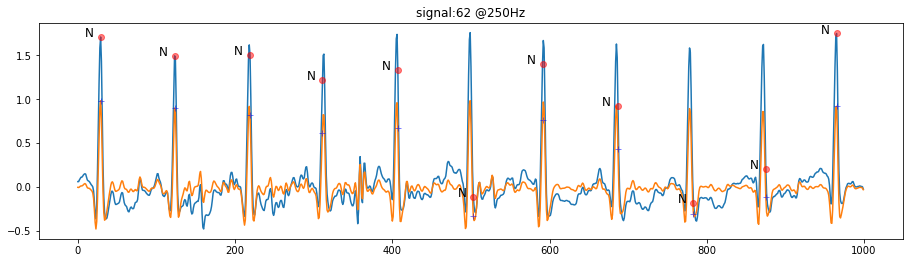

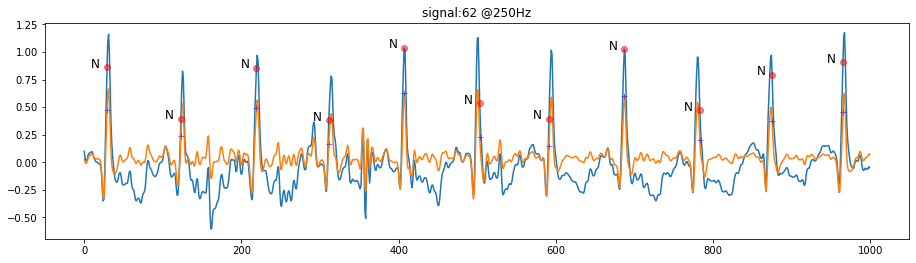

In [82]:
plot_count_250 = 0
plot_count_128 = 0
for i, signal in enumerate(ecg_signals):
  if (plot_count_250 < 3 and frequencies[i]==250) or (plot_count_128 <3 and frequencies[i]==128):
    plot_comparison(signal,signals_filt[i], i, 1000, lead=0, title="signal:"+str(i)+" @"+str(frequencies[i])+"Hz")
    plot_comparison(signal,signals_filt[i], i, 1000, lead=1, title="signal:"+str(i)+" @"+str(frequencies[i])+"Hz")
    if frequencies[i]==250:
      plot_count_250 += 1
    elif  frequencies[i]==128:
      plot_count_128 += 1



#Visualize filtering methods
Convolutions

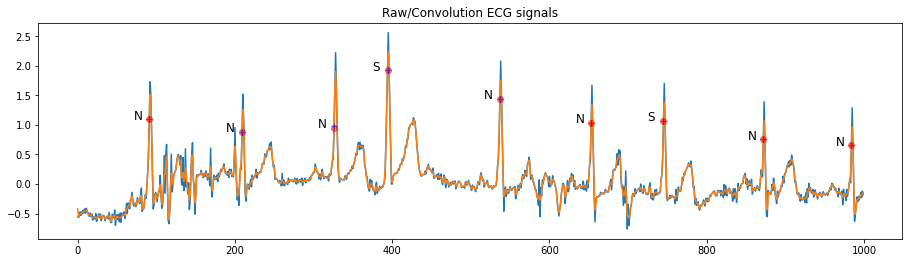

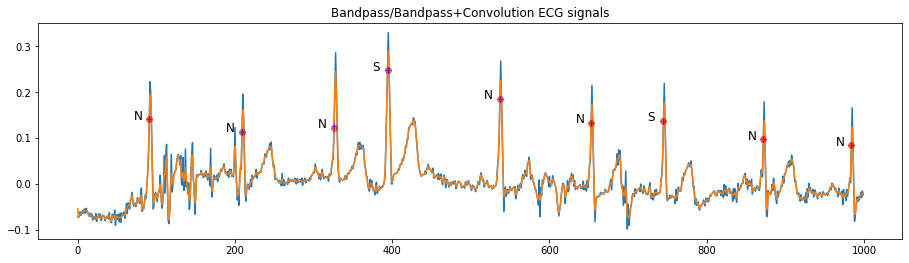

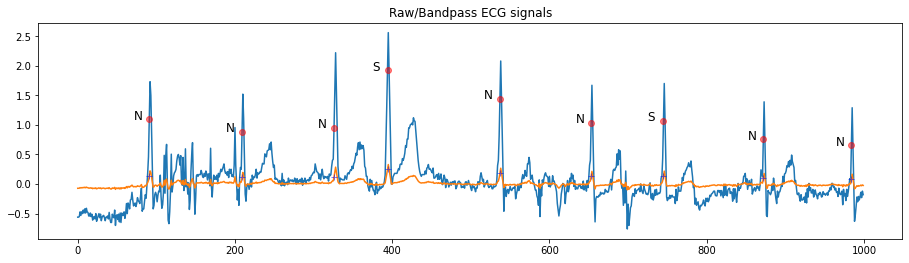

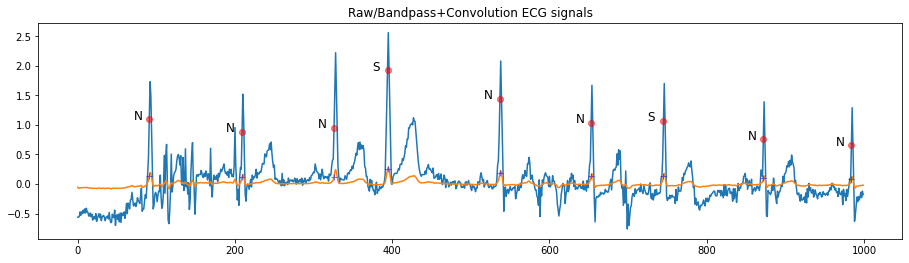

In [ ]:
# Filter using Convolution
# https://swharden.com/blog/2020-09-23-signal-filtering-in-python/
# create a normalized Hanning window
windowSize = 5
window = np.hanning(windowSize)
window = window / window.sum()
sigID=2
filtered = ecg_signals[sigID].copy()
# filter the data using convolution
filtered[:,0] = np.convolve(window, ecg_signals[sigID][:,0], mode='same')
filtered[:,1] = np.convolve(window, ecg_signals[sigID][:,1], mode='same')
plot_comparison(ecg_signals[sigID],filtered, sigID, 1000, title="Raw/Convolution ECG signals")



#try to do convolution on filtered signal
filtered = signal_preprocessing(ecg_signals[sigID], max_length= 450000, signal_freq = frequencies[i], lowcut= 4, highcut = 60, filter_order=3, apply_convolution=True)
bandpass_filtered = signal_preprocessing(ecg_signals[sigID], max_length= 450000, signal_freq = frequencies[i], lowcut= 4, highcut = 60, filter_order=3)
plot_comparison(bandpass_filtered,filtered, sigID, 1000, title="Bandpass/Bandpass+Convolution ECG signals")
plot_comparison(ecg_signals[sigID],bandpass_filtered, sigID, 1000, title="Raw/Bandpass ECG signals")
plot_comparison(ecg_signals[sigID],filtered, sigID, 1000, title="Raw/Bandpass+Convolution ECG signals")

heartpy lib methods effect and combinations

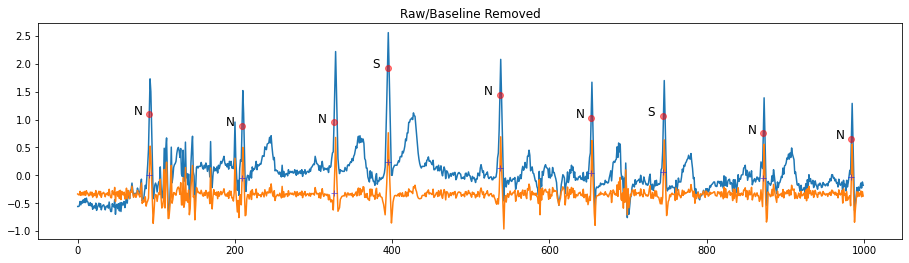

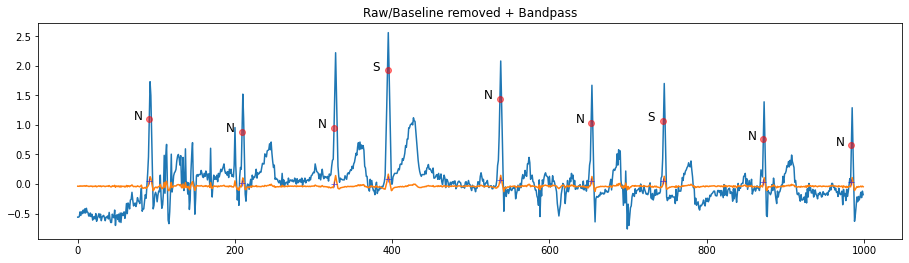

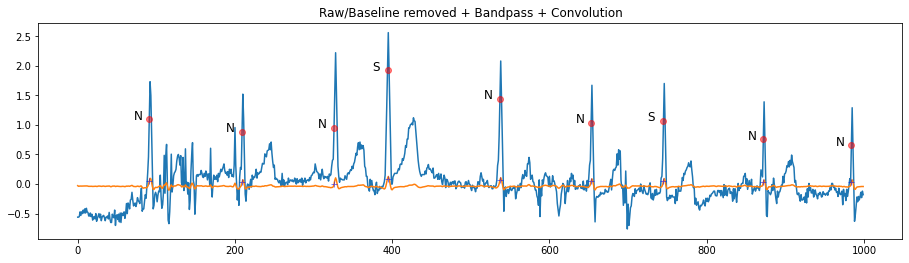

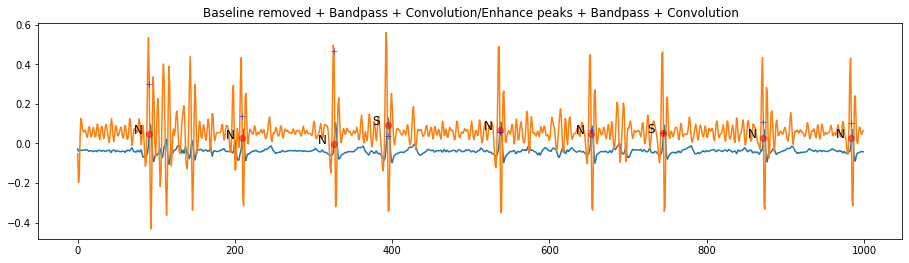

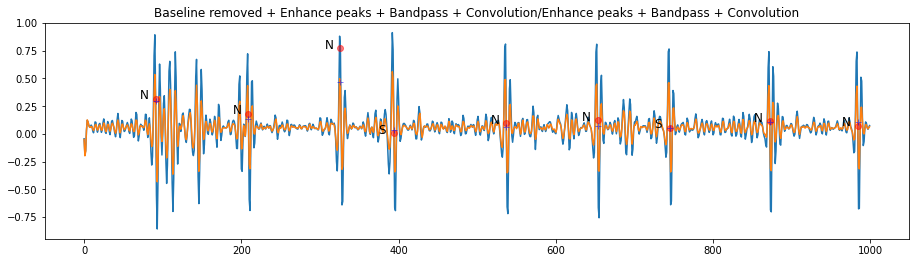

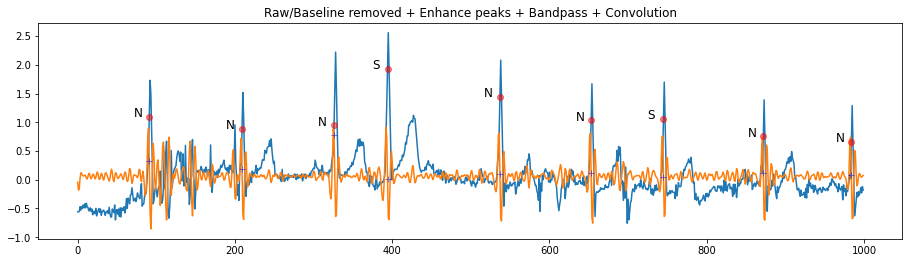

In [ ]:


filtered=ecg_signals[2].copy()



filtered[:,0] = hp.remove_baseline_wander(ecg_signals[2][:,0], frequencies[2])
filtered[:,1] = hp.remove_baseline_wander(ecg_signals[2][:,1], frequencies[2])
plot_comparison(ecg_signals[2], filtered, 2, 1000, title="Raw/Baseline Removed")



filtered = signal_preprocessing(ecg_signals[2], max_length= max_length, signal_freq = frequencies[i], lowcut= 4, highcut = 60, filter_order=3, remove_baseline_wander=True)
plot_comparison(ecg_signals[2], filtered, 2, 1000, title="Raw/Baseline removed + Bandpass")

filtered1  = signal_preprocessing(ecg_signals[2], max_length= 450000, signal_freq = frequencies[i], lowcut= 4, highcut = 60, filter_order=3, remove_baseline_wander=True, apply_convolution=True)
plot_comparison(ecg_signals[2], filtered1, 2, 1000, title="Raw/Baseline removed + Bandpass + Convolution")


filtered  = signal_preprocessing(ecg_signals[2], max_length= 450000, signal_freq = frequencies[i], lowcut= 4, highcut = 60, filter_order=3, remove_baseline_wander=False, apply_convolution=True, enhance_peaks=True)
plot_comparison(filtered1, filtered, 2, 1000, title="Baseline removed + Bandpass + Convolution/Enhance peaks + Bandpass + Convolution")


filtered2  = signal_preprocessing(ecg_signals[2], max_length= 450000, signal_freq = frequencies[i], lowcut= 4, highcut = 60, filter_order=3, remove_baseline_wander=True, apply_convolution=True, enhance_peaks=True)
plot_comparison(filtered2, filtered, 2, 1000, title="Baseline removed + Enhance peaks + Bandpass + Convolution/Enhance peaks + Bandpass + Convolution")

plot_comparison(ecg_signals[2], filtered2, 2, 1000, title="Raw/Baseline removed + Enhance peaks + Bandpass + Convolution")

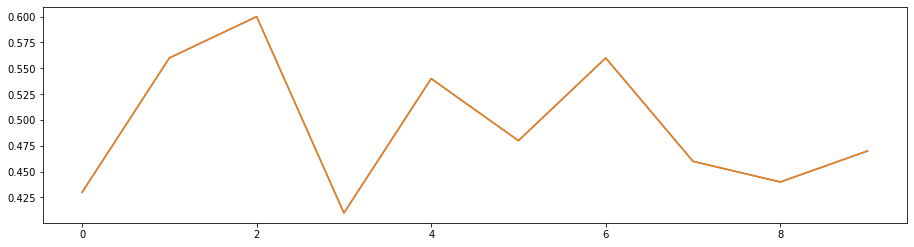

In [ ]:
#if we want to apply standard scaler to raw ecg signals

ecg_signals_np = np.zeros([len(ecg_signals),len(max(ecg_signals,key = lambda x: len(x))), 2])
for i,j in enumerate(ecg_signals):
    ecg_signals_np[i][0:len(j)] = j



nsamples, nx, ny = ecg_signals_np.shape
d2_signals = ecg_signals_np.reshape((nsamples,nx*ny))
scaler = StandardScaler()
scaler = scaler.fit(d2_signals)
scaler.transform(d2_signals)

d3_signals = d2_signals.reshape((nsamples,nx,ny))
plot_comparison(d3_signals[2], ecg_signals[2], 2, 10, lead=1)


In [ ]:
#if we want to apply standard scaler or MaxAbsScaler to filtered ecg signals
nsamples, nx, ny = signals_filt.shape
d2_signals_filt = signals_filt.reshape((nsamples,nx*ny))

scaler = MaxAbsScaler().fit(d2_signals_filt)
scaler.transform(d2_signals_filt)
#plt.plot(d2_signals_filt[0][:1000])
d3_signals_filt = d2_signals_filt.reshape((nsamples,nx,ny))
plot_comparison(d3_signals_filt[66], signals_filt[66], 66, 1000, lead=1)


d2_signals_filt = signals_filt.reshape((nsamples,nx*ny))

scaler = StandardScaler()
scaler = scaler.fit(d2_signals_filt)
scaler.transform(d2_signals_filt)
d3_signals_filt = d2_signals_filt.reshape((nsamples,nx,ny))
plot_comparison(d3_signals_filt[66], signals_filt[66], 66, 1000, lead=1)


#Transform labels with one-hot encoding for each signal



1.   N is for the normal beats
2.   S is for PAC beats
3.   V is for PVC beats
For each element of rpeaks, each label will be one_hot encoded (e.g. [ N, S, .. ] --> [ [1, 0, 0], [0, 1, 0], ..] )


#Plot label distribution

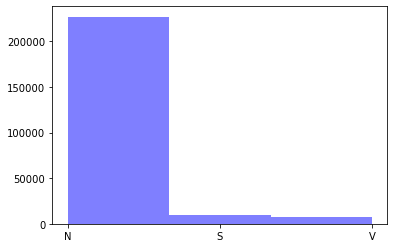

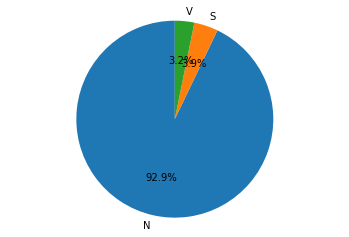

N beats samples: 226932
S beats samples: 9609
V beats samples: 7795


In [72]:
def count_classes(labels,classes):
    
    counts = [0]*len(classes)

    for i,k in enumerate(classes): # iterate over the classes is not the most efficient one, but it's more readable at the end 
        for label in labels:
            counts[i] += len(np.where(label == k)[0])

    return counts

classes = ["N","S","V"]

x = list()
counts = count_classes(labels,classes)

for i,k in enumerate(classes):
    x.extend([k]*counts[i])

num_bins = len(classes)
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

print(f"N beats samples: {counts[0]}")
print(f"S beats samples: {counts[1]}")
print(f"V beats samples: {counts[2]}")

This shows a strong unbalancing due to the huge amount of Normal beats, we must face this unbalance with some methods

In [9]:
#Create dataframe 
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

#use filtered signals instead of ecg_signals
for signal in signals_filt:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols
df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S010,"[1.2396870851516724, 1.5373122692108154, 1.324...","[-3.525822639465332, -4.685454845428467, -4.65...","[96, 169, 268, 360, 427, 539, 634, 714, 789, 8...",128,"[N, V, N, N, V, N, N, V, N, N, V, N, N, V, N, ..."
1,S009,"[0.3488556742668152, 0.5848020315170288, 0.497...","[-0.42589259147644043, -0.7890365123748779, -1...","[105, 205, 262, 410, 510, 611, 667, 812, 917, ...",128,"[N, N, V, N, N, N, V, N, N, N, V, N, N, N, V, ..."
2,S008,"[0.13484568893909454, 0.18088996410369873, 0.1...","[-0.14895685017108917, -0.1941940039396286, -0...","[71, 153, 232, 280, 367, 419, 537, 632, 682, 8...",128,"[N, N, N, S, N, S, N, N, S, N, N, S, N, V, N, ..."
3,S007,"[0.03260135278105736, 0.04130741208791733, 0.0...","[-0.27038589119911194, -0.38736769556999207, -...","[49, 129, 216, 298, 380, 466, 550, 631, 719, 8...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S006,"[0.1877303272485733, 0.2567766308784485, 0.266...","[0.1642550826072693, 0.22121839225292206, 0.22...","[67, 170, 278, 386, 492, 602, 662, 811, 886, 1...",128,"[N, N, N, N, N, N, V, N, V, N, V, N, V, N, V, ..."
...,...,...,...,...,...,...
100,S110,"[0.018148481845855713, 0.010064051486551762, -...","[-0.008254476822912693, -0.011460443027317524,...","[113, 259, 473, 615, 793, 961, 1157, 1339, 152...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S107,"[0.03709964454174042, 0.04486546665430069, 0.0...","[0.11095572263002396, 0.1491319090127945, 0.14...","[209, 449, 681, 913, 1145, 1373, 1603, 1829, 2...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
102,S108,"[0.03760737180709839, 0.048542410135269165, 0....","[0.042988598346710205, 0.057234026491642, 0.05...","[354, 543, 739, 934, 1129, 1327, 1526, 1723, 1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S109,"[0.1876121312379837, 0.25143054127693176, 0.26...","[0.008102865889668465, 0.009034287184476852, 0...","[55, 269, 497, 729, 963, 1203, 1443, 1677, 190...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [10]:
# dataset needs to be created because we need to classify beats and not the entire signal 
# We extract patches of a fixed length from the signal, given each of its peaks

classes = np.array(["N","S","V"])
peaks_labels = list()
def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)



dataset = dict()
length = 170

for l,id in enumerate(ids):
    for i,peak in enumerate(rpeaks[l]):
        
        dataset[id+"_"+str(i)] = {}
        dataset[id+"_"+str(i)]["first_lead"] = list()
        dataset[id+"_"+str(i)]["second_lead"] = list()
        p = peak

        for s in range(int(p-length/2),int(p+length/2)):

            if(s < 0 or s >= len(first_lead_signals[l])):   # padding with 0
                dataset[id+"_"+str(i)]["first_lead"].append(0.) 
                dataset[id+"_"+str(i)]["second_lead"].append(0.) 
            else:
                dataset[id+"_"+str(i)]["first_lead"].append(first_lead_signals[l][s])
                dataset[id+"_"+str(i)]["second_lead"].append(first_lead_signals[l][s])

        
        peaks_labels.append([labels[l][i]])
        dataset[id+"_"+str(i)]["label"] = convert_to_one_hot(labels[l][i])

dataset_df = pd.DataFrame.from_dict(dataset,orient="index")

dataset_df

is_NaN = dataset_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = dataset_df[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [first_lead, second_lead, label]
Index: []


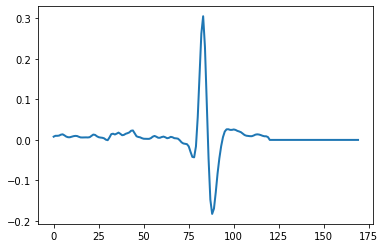

In [ ]:
#Visualization of an extracted patch
fig, ax = plt.subplots()
ax.plot(dataset_df["first_lead"]["S118_2451"], linewidth=2.0)


#Model experiments

In [ ]:
from sklearn.model_selection import train_test_split

# Training set

train_df, validation_df = train_test_split(balanced_df, test_size=0.2)

x_train_ = train_df[['first_lead','second_lead']].values

x_train = list()
for k in x_train_:
    x_train.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_train = np.asarray(x_train).astype(np.float32)

y_train = train_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)

# Validation set

x_valid_ = validation_df[['first_lead','second_lead']].values

x_valid = list()
for k in x_valid_:
    x_valid.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_valid = np.asarray(x_valid).astype(np.float32)

y_valid = validation_df['label'].values.tolist()
y_valid = np.asarray(y_valid).astype(np.float32)

print(len(x_train))

In [11]:
ecg_patches = dataset_df[['first_lead','second_lead']].values 
y_train = dataset_df['label'].values
x_train = list()

for k in ecg_patches:
    x_train.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_train = np.asarray(x_train).astype(np.float32)
y_train = dataset_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)


y_ = np.array([np.array(yi) for yi in y_train])
x_=np.array([np.array(xi) for xi in x_train])
print(len(y_))
print(len(dataset_df))

244336
244336


In [12]:
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=y_val_classes, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Training on fold 1
{(0.0, 0.0, 1.0): 6236, (0.0, 1.0, 0.0): 7687, (1.0, 0.0, 0.0): 181545}
{(0.0, 0.0, 1.0): 1559, (0.0, 1.0, 0.0): 1922, (1.0, 0.0, 0.0): 45387}


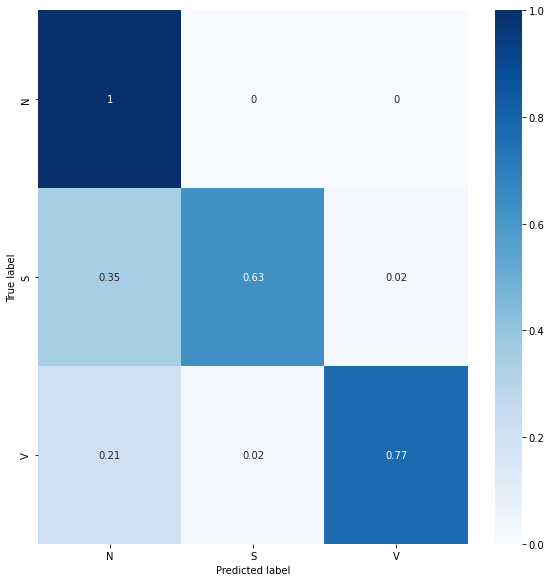

In [ ]:
#Simple randomforest classifier, without facing unbalancing


# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(x_, peaks_labels)):
    print("Training on fold " + str(index+1))
    # Generate batches from indices
    x_train, x_val = x_[train_indices], x_[val_indices]
    y_train, y_val = y_[train_indices], y_[val_indices]


    unique_train, counts_train = np.unique(y_train, axis = 0, return_counts=True)
    out_train = {tuple(i):j for i,j in zip(unique_train, counts_train)}
    print(out_train)
    unique_val, counts_val = np.unique(y_val, axis = 0, return_counts=True)
    out_val = {tuple(i):j for i,j in zip(unique_val, counts_val)}
    print(out_val)
    

    #Create a Random Forest Classifier using skit
    clf=RandomForestClassifier(n_estimators=100, class_weight=None, random_state= SEED)
    #Train the model using the training sets 
    #Note that scikit RandomForest need a 2Dimensional array as input

    #nsamples, nx, ny = x_train.shape
    #d2_x_train = x_train.reshape((nsamples,nx*ny)) #reshape x_train into 2 dimensions 

    clf.fit(x_train,y_train) #train the model 

    #nsamples, nx, ny = x_val.shape
    #d2_x_val = x_val.reshape((nsamples,nx*ny)) #reshape x_val into 2 dimensions
    
    y_pred=clf.predict(x_val) #predict the validation set classes
    y_pred=np.argmax(y_pred,axis=1)
    y_val_classes=np.argmax(y_val, axis=1)

    plot_confusion_matrix(y_val_classes, y_pred)
    
    #It's just a test, only one iteration of kfold is performed
    break

Training on fold 1
{(0.0, 0.0, 1.0): 6236, (0.0, 1.0, 0.0): 7687, (1.0, 0.0, 0.0): 181545}
{(0.0, 0.0, 1.0): 1559, (0.0, 1.0, 0.0): 1922, (1.0, 0.0, 0.0): 45387}


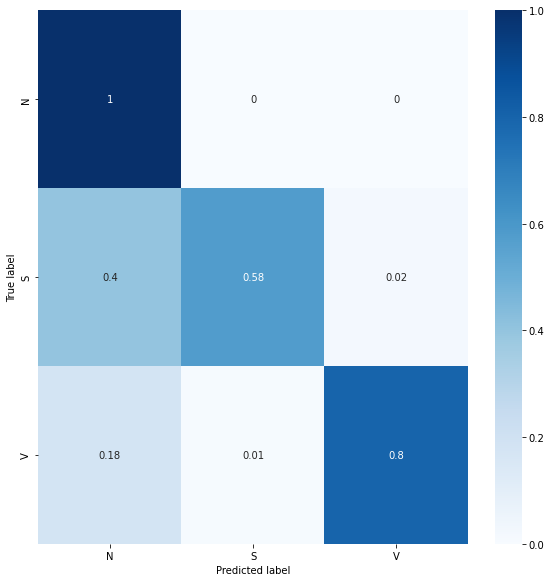

In [ ]:
#Random forest + class_weights
ecg_patches_np = np.array(ecg_patches)
peaks_labels_np = np.array(peaks_labels)
#one_hot_peaks_labels_np = np.array(one_hot_peaks_labels)
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(ecg_patches, peaks_labels)):
    print("Training on fold " + str(index+1))
    # Generate batches from indices
    x_train, x_val = x_[train_indices], x_[val_indices]
    y_train, y_val = y_[train_indices], y_[val_indices]


    unique_train, counts_train = np.unique(y_train, axis = 0, return_counts=True)
    out_train = {tuple(i):j for i,j in zip(unique_train, counts_train)}
    print(out_train)
    unique_val, counts_val = np.unique(y_val, axis = 0, return_counts=True)
    out_val = {tuple(i):j for i,j in zip(unique_val, counts_val)}
    print(out_val)
    

    #Create a Random Forest Classifier using skit
    #In order to use class_weight parameter of RandomForest, we generate a class_weight dictionary from the computed weights
    y_train_classes = np.argmax(y_train, axis=1)
    class_weights =  compute_class_weight('balanced', classes= np.unique(y_train_classes), y = y_train_classes)


    class_weights_dict = {
        0: class_weights[0],
        1: class_weights[1],
        2: class_weights[2]
    }

    clf=RandomForestClassifier(n_estimators=100, class_weight= class_weights_dict, random_state= SEED)
    #Train the model using the training sets 
    #Note that scikit RandomForest need a 2Dimensional array as input

    #nsamples, nx, ny = x_train.shape
    #d2_x_train = x_train.reshape((nsamples,nx*ny)) #reshape x_train into 2 dimensions 
    #we use then the y_train_classes in order to match the labels shape in the weights dictionary
    clf.fit(x_train,y_train_classes) #train the model 

    #nsamples, nx, ny = x_val.shape
    #d2_x_val = x_val.reshape((nsamples,nx*ny)) #reshape x_val into 2 dimensions
    
    y_pred=clf.predict(x_val) #predict the validation set classes
    #y_pred=np.argmax(y_pred,axis=1)
    y_val_classes=np.argmax(y_val, axis=1)

    plot_confusion_matrix(y_val_classes, y_pred)

    
    #It's just a test, only one iteration of kfold is performed
    break

In [ ]:
#Build a simple feed forward NN

def build_ffnn(input_shape, out_classes, custom_loss=None):

    # Build the neural network layer by layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')
    hidden_layer1 = tf.keras.layers.Dense(units=128, activation='relu', name='Hidden1')(input_layer)
    hidden_layer2 = tf.keras.layers.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
    flatten = tf.keras.layers.Flatten()(hidden_layer2)#tf.keras.layers.GlobalMaxPool1D()(hidden_layer2)
    output_layer = tf.keras.layers.Dense(units=out_classes, activation='sigmoid', name='Output')(flatten)

    # Connect input and output through the Model class
    model = Model(inputs=input_layer, outputs=output_layer, name='FFNN')

    # Compile the model
    if custom_loss is None:
      loss = 'categorical_crossentropy'
    else:
      loss = custom_loss
      
    learning_rate = 2.5e-4
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics = 'accuracy')

    # Return the model
    return model





In [ ]:
print(x_train.shape)
print(y_train.shape)

(8820, 340)
(8820, 3)


Training on fold 1
Epoch 1/10
3055/3055 [==============================] - 10s 3ms/step - loss: 0.2367 - accuracy: 0.9306 - val_loss: 0.3185 - val_accuracy: 0.9134
Epoch 2/10
3055/3055 [==============================] - 8s 3ms/step - loss: 0.2507 - accuracy: 0.9285 - val_loss: 0.2821 - val_accuracy: 0.9288
Epoch 3/10
3055/3055 [==============================] - 8s 3ms/step - loss: 0.2602 - accuracy: 0.9287 - val_loss: 0.2554 - val_accuracy: 0.9288
Epoch 4/10
3055/3055 [==============================] - 8s 3ms/step - loss: 0.2502 - accuracy: 0.9286 - val_loss: 0.2681 - val_accuracy: 0.9288
Epoch 5/10
3055/3055 [==============================] - 8s 3ms/step - loss: 0.2656 - accuracy: 0.9283 - val_loss: 0.2553 - val_accuracy: 0.9295
Epoch 6/10
3055/3055 [==============================] - 8s 3ms/step - loss: 0.2388 - accuracy: 0.9286 - val_loss: 0.2884 - val_accuracy: 0.9288
Epoch 7/10
3055/3055 [==============================] - 8s 3ms/step - loss: 0.2784 - accuracy: 0.9286 - val_loss: 0.

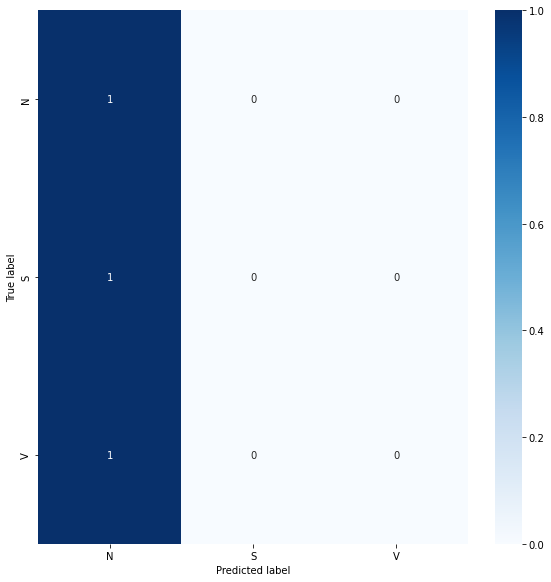

In [ ]:
#Simple Feed Forward NN to test baseline performances

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(x_, peaks_labels)):
    print("Training on fold " + str(index+1))
    # Generate batches from indices
    x_train, x_val = x_[train_indices], x_[val_indices]
    y_train, y_val = y_[train_indices], y_[val_indices]

    
    FFN = build_ffnn(x_train.shape[1], 3)
    history = FFN.fit(
    x = x_train,
    y = y_train, 
    validation_data=(x_val, y_val),
    batch_size = 64,
    epochs = 10
    ).history


    y_pred= FFN.predict(x_val)
    y_pred=np.argmax(y_pred,axis=1)
    y_val_classes=np.argmax(y_val, axis=1)

    plot_confusion_matrix(y_val_classes, y_pred)


    #It's a test, just one iteration performed of k-fold
    #Otherwise we must keep each trained model and then perfomr ensambling
    break



#Weighted loss function:
We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows:
$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is:
$$freq_{p} = \frac{\text{number of positive examples}}{N} $$$$\text{and}$$$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$


In [13]:
#From lesson 6
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def compute_weighted_loss_params(y_train):
    freq_pos, freq_neg = compute_class_freqs(y_train)
    print(f"pos freqs: {freq_pos}")

    print(f"neg freqs: {freq_neg}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    plot_occ = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": freq_pos})
    plot_occ = plot_occ.append([{"Class": classes[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
    plt.xticks(rotation=90)
    f = sns.barplot(ax = axes[0], x="Class", y="Value", hue="Label" ,data=plot_occ)
    pos_weights = freq_neg
    neg_weights = freq_pos
    pos_contribution = freq_pos * pos_weights 
    neg_contribution = freq_neg * neg_weights
    plot_occ = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": pos_contribution})
    plot_occ = plot_occ.append([{"Class": classes[l], "Label": "Negative", "Value": v} 
                            for l,v in enumerate(neg_contribution)], ignore_index=True)
    plt.xticks(rotation=90)
    sns.barplot(ax = axes[1], x="Class", y="Value", hue="Label" ,data=plot_occ)
    return pos_weights, neg_weights


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))
        return loss    
    return weighted_loss

Training on fold 1
pos freqs: [0.92877095 0.03932613 0.03190292]
neg freqs: [0.07122905 0.96067387 0.96809708]
Epoch 1/10
3055/3055 [==============================] - 15s 4ms/step - loss: 0.1293 - accuracy: 0.8261 - val_loss: 0.1210 - val_accuracy: 0.8586
Epoch 2/10
3055/3055 [==============================] - 9s 3ms/step - loss: 0.1056 - accuracy: 0.8909 - val_loss: 0.0849 - val_accuracy: 0.9296
Epoch 3/10
3055/3055 [==============================] - 9s 3ms/step - loss: 0.1051 - accuracy: 0.8896 - val_loss: 0.1361 - val_accuracy: 0.8239
Epoch 4/10
3055/3055 [==============================] - 9s 3ms/step - loss: 0.0990 - accuracy: 0.9163 - val_loss: 0.0835 - val_accuracy: 0.9285
Epoch 5/10
3055/3055 [==============================] - 9s 3ms/step - loss: 0.0951 - accuracy: 0.9009 - val_loss: 0.0864 - val_accuracy: 0.9198
Epoch 6/10
3055/3055 [==============================] - 9s 3ms/step - loss: 0.0979 - accuracy: 0.9142 - val_loss: 0.0892 - val_accuracy: 0.9327
Epoch 7/10
3055/3055 [==

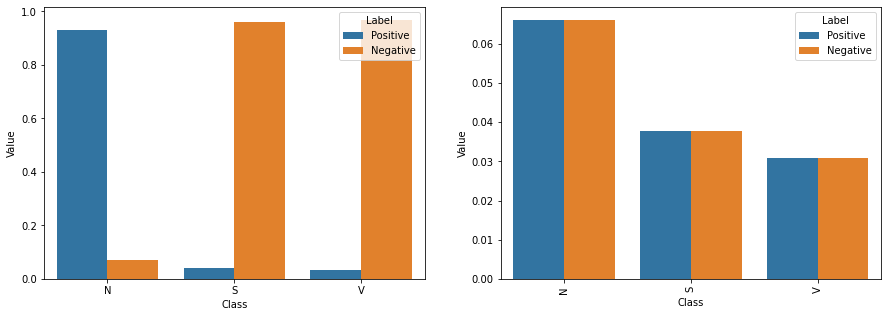

In [ ]:
ecg_patches_np = np.array(ecg_patches)
peaks_labels_np = np.array(peaks_labels)
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(ecg_patches, peaks_labels)):
    print("Training on fold " + str(index+1))
    # Generate batches from indices
    x_train, x_val = x_[train_indices], x_[val_indices]
    y_train, y_val = y_[train_indices], y_[val_indices]
    
    pos_weights, neg_weights = compute_weighted_loss_params(y_train)
    FFN = build_ffnn(x_train.shape[1], 3, custom_loss = get_weighted_loss(pos_weights, neg_weights))
    history = FFN.fit(
    x = x_train,
    y = y_train, 
    validation_data=(x_val, y_val),
    batch_size = 64,
    epochs = 10
    #class_weight= class_weights_dict
    ).history

    break

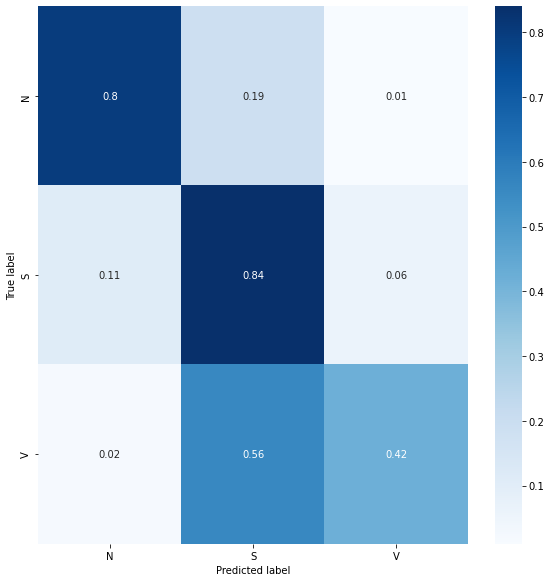

In [ ]:
y_pred= FFN.predict(x_val)
y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_val, axis=1)
plot_confusion_matrix(y_val_classes, y_pred)


Training on fold 1
pos freqs: [0.92877095 0.03932613 0.03190292]
neg freqs: [0.07122905 0.96067387 0.96809708]
[0.07122905 0.96067387 0.96809708]
[0.92877095 0.03932613 0.03190292]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 340, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 316, 64)           1664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 158, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 128)          98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 73, 128)          0         
 1D)        

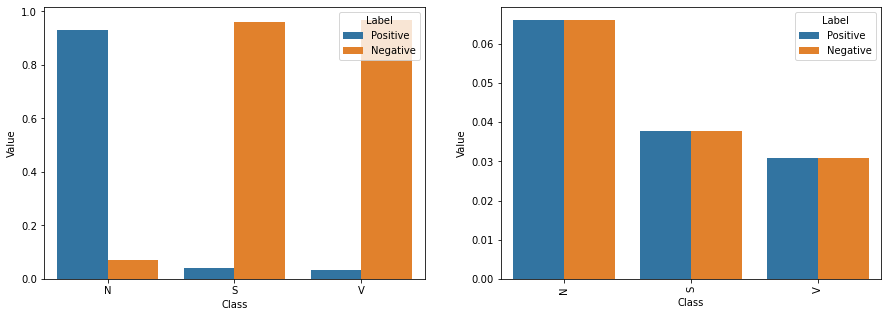

In [16]:
def neuralNet(input_shape, out_classes, custom_loss=None):
    
    input = tf.keras.layers.Input(shape=input_shape, name='Input')

    conv1 = keras.layers.Conv1D(filters=64,kernel_size=25,strides=1,padding="valid",activation="relu")(input)
    maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
    conv2 = keras.layers.Conv1D(filters=128,kernel_size=12,strides=1,padding="valid",activation="relu")(maxPool1)
    maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=9,strides=1,padding="valid",activation="relu")(maxPool2)
    maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv2)
    conv3= keras.layers.Conv1D(filters=256,kernel_size=5,strides=1,padding="valid",activation="relu")(maxPool3)
    maxPool4 = keras.layers.MaxPool1D(pool_size=2)(conv3)
    gap = keras.layers.GlobalAveragePooling1D()(maxPool4)
    
    hidden1 = keras.layers.Dense(1024, activation=tf.nn.relu,kernel_regularizer=keras.regularizers.l2(0.01),
                                 bias_regularizer=keras.regularizers.l2(0.01))(gap)
    hidden2 = keras.layers.Dense(512, activation=tf.nn.relu,kernel_regularizer=keras.regularizers.l2(0.01),
                                 bias_regularizer=keras.regularizers.l2(0.01))(hidden1)
    output = keras.layers.Dense(3, activation=tf.nn.softmax)(hidden2)
    model = keras.models.Model(inputs=input, outputs=output)

    # Compile the model
    if custom_loss is None:
      loss = 'categorical_crossentropy'
    else:
      loss = custom_loss
      
    learning_rate = 2.5e-4
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics = 'accuracy')

    # summarize layers
    print(model.summary())
    # plot graph
    #plot_model(model, to_file='convolutional_neural_network.png')
    return model

import gc

gc.collect()
ecg_patches_np = np.array(ecg_patches)
peaks_labels_np = np.array(peaks_labels)




#one_hot_peaks_labels_np = np.array(one_hot_peaks_labels)
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(ecg_patches, peaks_labels)):
    print("Training on fold " + str(index+1))
    # Generate batches from indices
    x_train, x_val = x_[train_indices], x_[val_indices]
    y_train, y_val = y_[train_indices], y_[val_indices]
    
    #In order to use class_weight parameter, we generate a class_weight dictionary from the computed weights
    y_train_classes = np.argmax(y_train, axis=1)
    class_weights =  compute_class_weight('balanced', classes= np.unique(y_train_classes), y = y_train_classes)


    class_weights_dict = {
      0: class_weights[0],
      1: class_weights[1],
      2: class_weights[2]
    }

    pos_weights, neg_weights = compute_weighted_loss_params(y_train)
    print(pos_weights)
    print(neg_weights)
    NN = neuralNet((x_train.shape[1], 1), 3, custom_loss = get_weighted_loss(pos_weights, neg_weights))
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode="auto")
    pl=ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,verbose=1,min_lr=1e-11)
    callbacks = [es]#,pl]

    history = NN.fit(
    x = x_train,
    y = y_train, 
    validation_data=(x_val, y_val),
    batch_size = 64,
    epochs = 50,
    class_weight= class_weights_dict,
    callbacks=callbacks
    ).history

    break


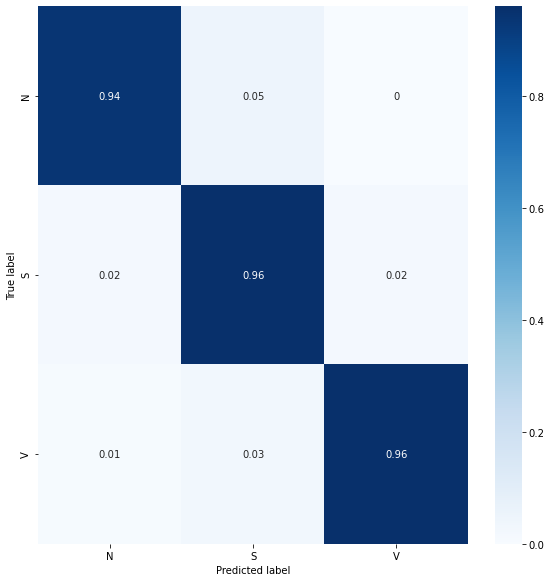

In [17]:
y_pred= NN.predict(x_val)
y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_val, axis=1)
plot_confusion_matrix(y_val_classes, y_pred)


In [18]:
#Different from before, we keep distinction between leads so that x_ shape is (n_patches, patch_length, n_leads=2)

ecg_patches = dataset_df[['first_lead','second_lead']].values 
y_train = dataset_df['label'].values
x_train = list()

for k in ecg_patches:
    x_train.append(np.asarray([k[0],k[1]]).astype(np.float32))
x_train = np.asarray(x_train).astype(np.float32)
y_train = dataset_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)


y_ = np.array([np.array(yi) for yi in y_train])
x_=np.array([np.array(xi) for xi in x_train])
x_ = np.moveaxis(x_, -1, 1)
print(x_.shape)
print(len(dataset_df))

(244336, 170, 2)
244336


Training on fold 1
pos freqs: [0.92877095 0.03932613 0.03190292]
neg freqs: [0.07122905 0.96067387 0.96809708]
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 170, 2)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 170, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 170, 64)     256         ['conv1d_4[0][0]']               
 alization)                                                                                       
                                                                                

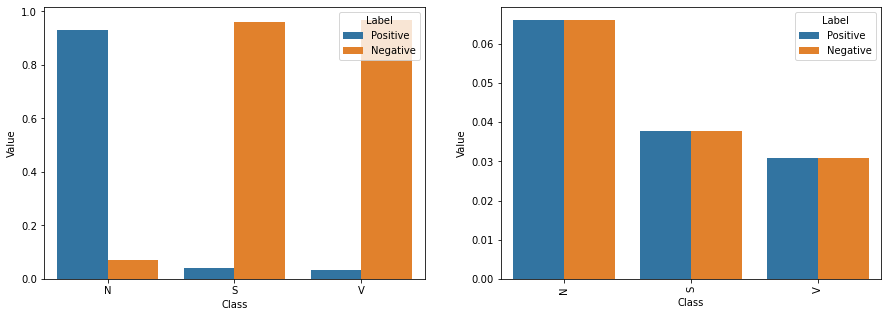

In [19]:
# ResNet model definition 


def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = keras.layers.Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

#N= number of blocks in resnet, ch = different channels, win_len = common lenght for ecg signals, classes=..
def resnet(input_shape, out_classes, N=8, custom_loss = None): 
    ecg_input = Input(shape=input_shape, name='ecg_signal') 

    ResNet = keras.layers.Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = keras.layers.MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    #Not necessary?
    #ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer to retrieve all the combination, instead of softmax
    ResNet = Dense(out_classes, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input],outputs=ResNet)


    # Compile the model
    if custom_loss is None:
      loss = 'categorical_crossentropy'
    else:
      loss = custom_loss

    learning_rate = 2.5e-4
    model.compile(
        optimizer = keras.optimizers.Adam(),
        loss = loss,
        metrics = ['accuracy']#, 'Precision', 'Recall' ]
    )


    # summarize layers
    print(model.summary())
    # plot graph
    #plot_model(model, to_file='convolutional_neural_network.png')
    return model

import gc

gc.collect()
ecg_patches_np = np.array(ecg_patches)
peaks_labels_np = np.array(peaks_labels)
#one_hot_peaks_labels_np = np.array(one_hot_peaks_labels)
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(ecg_patches, peaks_labels)):
    print("Training on fold " + str(index+1))
    # Generate batches from indices
    x_train, x_val = x_[train_indices], x_[val_indices]
    y_train, y_val = y_[train_indices], y_[val_indices]
    
    pos_weights, neg_weights = compute_weighted_loss_params(y_train)
    ResNet = resnet((x_train.shape[1], 2), 3, custom_loss = get_weighted_loss(pos_weights, neg_weights))
    y_train_classes = np.argmax(y_train, axis=1)
    class_weights =  compute_class_weight('balanced', classes= np.unique(y_train_classes), y = y_train_classes)
    class_weights_dict = {
      0: class_weights[0],
      1: class_weights[1],
      2: class_weights[2]
    }
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode="auto")
    pl=ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,verbose=1,min_lr=1e-11)
    callbacks = [es,pl]

    history = ResNet.fit(
    x = x_train,
    y = y_train, 
    validation_data=(x_val, y_val),
    batch_size = 64,
    epochs = 50,
    class_weight= class_weights_dict,
    callbacks = callbacks
    ).history

    break


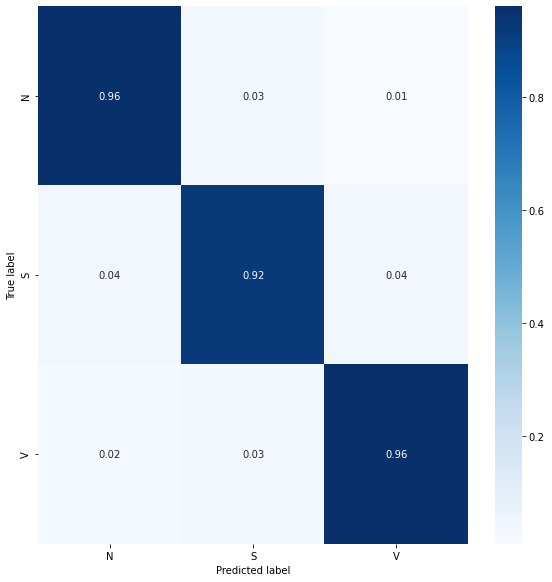

In [20]:
y_pred= ResNet.predict(x_val)
y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_val, axis=1)
plot_confusion_matrix(y_val_classes, y_pred)

Training on fold 1
pos freqs: [0.92877095 0.03932613 0.03190292]
neg freqs: [0.07122905 0.96067387 0.96809708]
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 170, 2)]     0           []                               
                                                                                                  
 conv1d_124 (Conv1D)            (None, 170, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization_120 (Batch  (None, 170, 64)     256         ['conv1d_124[0][0]']             
 Normalization)                                                                                   
                                                                                

C:\Users\user\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


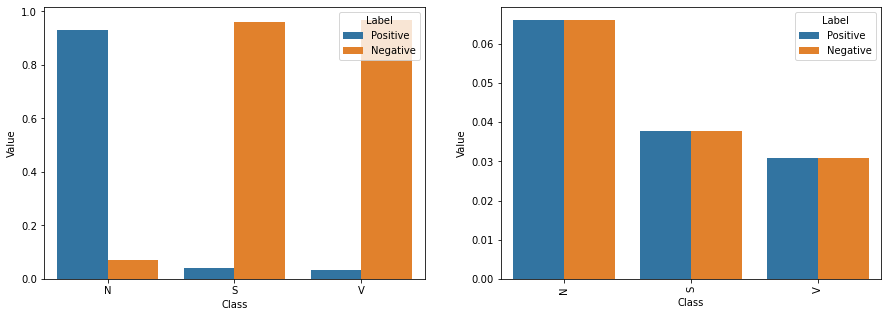

In [22]:
import gc

gc.collect()
ecg_patches_np = np.array(ecg_patches)
peaks_labels_np = np.array(peaks_labels)
#one_hot_peaks_labels_np = np.array(one_hot_peaks_labels)
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(ecg_patches, peaks_labels)):
    gc.collect()
    print("Training on fold " + str(index+1))
    # Generate batches from indices
    x_train, x_val = x_[train_indices], x_[val_indices]
    y_train, y_val = y_[train_indices], y_[val_indices]
    
    pos_weights, neg_weights = compute_weighted_loss_params(y_train)
    ResNet = resnet((x_train.shape[1], 2), 3, custom_loss = get_weighted_loss(pos_weights, neg_weights))
    y_train_classes = np.argmax(y_train, axis=1)
    class_weights =  compute_class_weight('balanced', classes= np.unique(y_train_classes), y = y_train_classes)
    class_weights_dict = {
      0: class_weights[0],
      1: class_weights[1],
      2: class_weights[2]
    }
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode="auto")
    pl=ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,verbose=1,min_lr=1e-11)
    callbacks = [es,pl]


    history = ResNet.fit(
    x = x_train,
    y = y_train, 
    validation_data=(x_val, y_val),
    batch_size = 64,
    epochs = 50,
    class_weight= class_weights_dict,
    callbacks = callbacks
    ).history
    ResNet.save(os.path.join(cwd,"ModelFold{}.h5".format(index)))

In [ ]:
def build_VGG(input_shape, out_classes, custom_loss=None):
  model = Sequential()
  model.add(keras.layers.Conv1D(input_shape=input_shape,filters=64,kernel_size=3,padding="same", activation="relu"))
  model.add(keras.layers.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
  model.add(keras.layers.MaxPool1D(pool_size=2,strides=2))
  model.add(keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.MaxPool1D(pool_size=2,strides=2))
  model.add(keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.MaxPool1D(pool_size=2,strides=2))
  model.add(keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.MaxPool1D(pool_size=2,strides=2))
  model.add(keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
  model.add(keras.layers.MaxPool1D(pool_size=2,strides=2))
  model.add(keras.layers.MaxPool1D(pool_size=2))
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(keras.layers.Dense(units=4096,activation="relu"))
  #model.add (keras.layers.Dropout(0.4))
  model.add(keras.layers.Dense(units=out_classes, activation="softmax"))



  # Compile the model
  if custom_loss is None:
    loss = 'categorical_crossentropy'
  else:
    loss = custom_loss

  learning_rate = 2.5e-4
  model.compile(
      optimizer = keras.optimizers.Adam(),
      loss = loss,
      metrics = ['accuracy']#, 'Precision', 'Recall' ]
  )


  # summarize layers
  print(model.summary())
  # plot graph
  #plot_model(model, to_file='convolutional_neural_network.png')
  return model

import gc

gc.collect()
ecg_patches_np = np.array(ecg_patches)
peaks_labels_np = np.array(peaks_labels)
#one_hot_peaks_labels_np = np.array(one_hot_peaks_labels)
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(ecg_patches, peaks_labels)):
    print("Training on fold " + str(index+1))
    # Generate batches from indices
    x_train, x_val = x_[train_indices], x_[val_indices]
    y_train, y_val = y_[train_indices], y_[val_indices]
    
    pos_weights, neg_weights = compute_weighted_loss_params(y_train)
    VGG = build_VGG((x_train.shape[1], 2), 3)#, custom_loss = get_weighted_loss(pos_weights, neg_weights))
    y_train_classes = np.argmax(y_train, axis=1)
    class_weights =  compute_class_weight('balanced', classes= np.unique(y_train_classes), y = y_train_classes)
    class_weights_dict = {
      0: class_weights[0],
      1: class_weights[1],
      2: class_weights[2]
    }
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode="auto")
    pl=ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,verbose=1,min_lr=1e-11)
    callbacks = [es,pl]

    history = VGG.fit(
    x = x_train,
    y = y_train, 
    validation_data=(x_val, y_val),
    batch_size = 64,
    epochs = 50,
    class_weight= class_weights_dict,
    callbacks = callbacks
    ).history

    break



Training on fold 1
pos freqs: [0.92877095 0.03932613 0.03190292]
neg freqs: [0.07122905 0.96067387 0.96809708]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_157 (Conv1D)         (None, 170, 64)           448       
                                                                 
 conv1d_158 (Conv1D)         (None, 170, 64)           12352     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 85, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_159 (Conv1D)         (None, 85, 128)           24704     
                                                                 
 conv1d_160 (Conv1D)         (None, 85, 128)           49280     
                                                                 
 max_pool

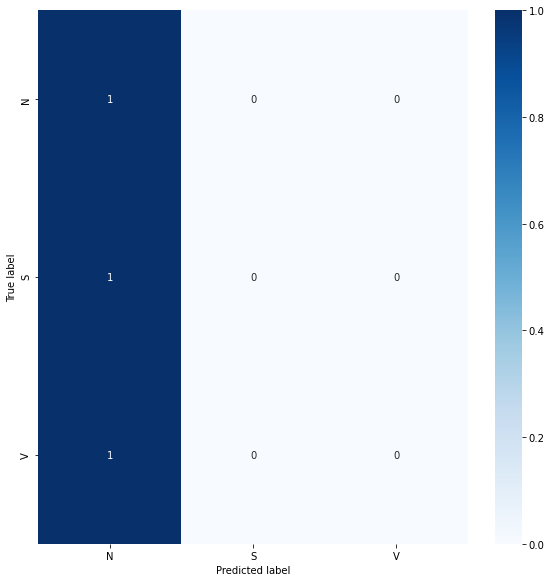

In [29]:
y_pred= VGG.predict(x_val)
y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_val, axis=1)
plot_confusion_matrix(y_val_classes, y_pred)